In [1]:
from lib.utilities import *
import matplotlib.pyplot as plt

%matplotlib widget

In [2]:
datadir = "./tsm_targets/05-25-22/1-1" # All files in this directory + subdirectories are loaded
#datadir = "./tsm_targets" # All files in this directory + subdirectories are loaded
#datadir = "C:/Turbo-SM/SMDATA/Untitled"
#datadir = "C:/Turbo-SM/SMDATA/John/01-17-22"
selected_filename = "Untitled005" # focus for subsequent analysis
#selected_filename = "OMP25-Cerulean3-cell4003"
file_type = '.tsm'
camera_program = 4

In [3]:
cam_settings = CameraSettings().get_program_settings(camera_program)
print(cam_settings)

t_cropping = [0, -1]  # to handle artifacts
binning = int(cam_settings['height'] / 80)  # recommended binning, adjust as desired

{'interval_between_samples': 0.5, 'width': 512, 'height': 160, 'camera_program': 4, 'cropping': [176, 336]}


In [4]:
# Load data
data_loader = DataLoader()
if file_type == '.tsm':
    data_loader.load_all_tsm(data_dir=datadir, file_only=selected_filename)
    
print(data_loader.get_n_files_loaded(), "files loaded.")

Untitled005.tbn
Untitled005.tsm
./tsm_targets/05-25-22/1-1/Untitled005.tsm to be treated as TSM file to open
Reading file as 200 images of size 512 x 160
TBN file designates origin as NI for this data.
Found 4 channels in BNC ratio: 1
{'points_per_trace': 200, 'raw_width': 512, 'raw_height': 160, 'interval_between_samples': 0.5, 'number_of_trials': 1}
Untitled007.tbn
Untitled007.tsm
1 files loaded.


In [5]:
# Select data of interest        
selected_data = data_loader.select_data_by_keyword(selected_filename)

# binning and cropping
selected_data.clip_data(y_range=cam_settings['cropping'], t_range=t_cropping)
selected_data.bin_data(binning=binning)

# load data
raw_data, meta, rli = selected_data.get_data(), selected_data.get_meta(), selected_data.get_rli()
fp_data = selected_data.fp_data

{'points_per_trace': 199, 'raw_width': 199, 'raw_height': -40, 'interval_between_samples': 0.5, 'number_of_trials': 1} (1, 199, 159, 160)


(1, 199, 80, 80)


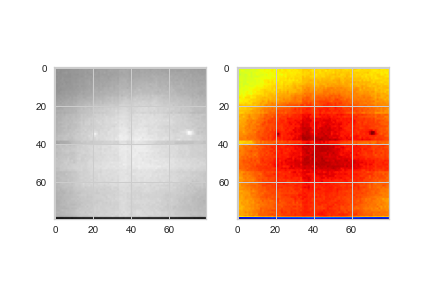

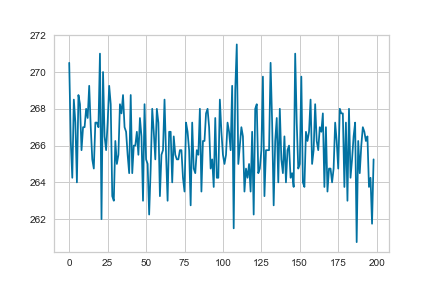

In [6]:
# if we're just one off, auto-correct for the user
if raw_data.shape[2] - raw_data.shape[3] == 1:
    raw_data = raw_data[:, :, :-1, :]
elif raw_data.shape[3] - raw_data.shape[2] == 1:
    raw_data = raw_data[:, :, :, :-1]
print(raw_data.shape)

# view frames
fig, axes = plt.subplots(1, 2)
axes[0].imshow(raw_data[0,0,:,:],cmap='gray')
axes[1].imshow(raw_data[0,-1,:,:],cmap='jet')
plt.show()

rli_high_cp = np.copy(raw_data[0,0,:,:]).astype(np.uint16)
plt.subplots()
plt.plot(raw_data[0,:,0,0])

# final check 
if raw_data.shape[2] != raw_data.shape[3]:
    raise Exception("PhotoZ will not work with non-square array! Adjust cropping and/or binning")

In [7]:
# Fill in missing metadata
meta['version'] = 5
meta['slice_number'] = 5
meta['location_number'] = 5
meta['record_number'] = 5
meta['camera_program'] = cam_settings['camera_program']

meta['interval_between_trials'] = 1
meta['acquisition_gain'] = 1
meta['time_RecControl'] = 5

meta['reset_onset'] = 1
meta['reset_duration'] = 5
meta['shutter_onset'] = 5
meta['shutter_duration'] = 5

meta['stimulation1_onset'] = 20
meta['stimulation1_duration'] = 1
meta['stimulation2_onset'] = 0
meta['stimulation2_duration'] = 0

meta['acquisition_onset'] = 1
meta['interval_between_samples'] = cam_settings['interval_between_samples']

meta['raw_width'] = raw_data.shape[2]
meta['raw_height'] = raw_data.shape[3]
meta['points_per_trace'] = raw_data.shape[1]
meta['number_of_trials'] = raw_data.shape[0]
meta['num_fp_pts'] = 8
num_diodes = int(meta['raw_width'] * meta['raw_height'] + meta['num_fp_pts'])
rli = {}
rli['rli_low'] = np.zeros((num_diodes), dtype = np.uint16)
rli['rli_high'] = np.zeros((num_diodes), dtype = np.uint16) 
rli['rli_high'][:meta['raw_width'] * meta['raw_height']] = rli_high_cp.reshape(-1)
rli['rli_max'] = np.ones((num_diodes), dtype = np.uint16)


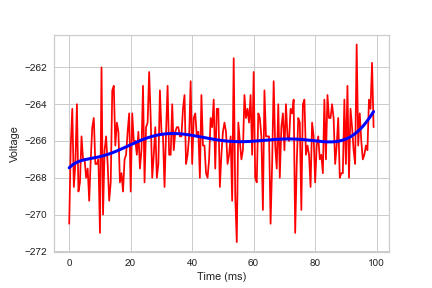

In [8]:
# Run this cell at most once

# Apply baseline correction here. Because PhotoZ chokes on baseline correcting TurboSM data
tr = Tracer()
#data inversing
raw_data = -raw_data

# Need to subtract off the low-frequency voltage drift. First-order correction
tr.correct_background(meta, raw_data)
#plt.subplots() # finalize plot 

(1, 199, 80, 80)


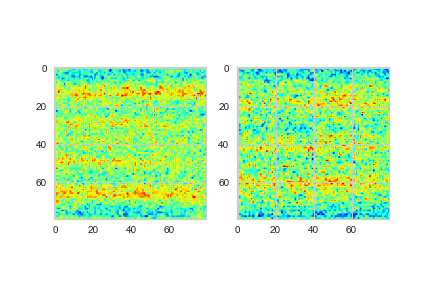

In [9]:

# normalize raw data to 12-bit range
fp_data = normalize_bit_range(fp_data)
raw_data = normalize_bit_range(raw_data)

# view frames
fig, axes = plt.subplots(1, 2)
print(raw_data.shape)
axes[0].imshow(raw_data[0,0,:,:],cmap='jet')
axes[1].imshow(raw_data[0,-1,:,:],cmap='jet')
plt.show()


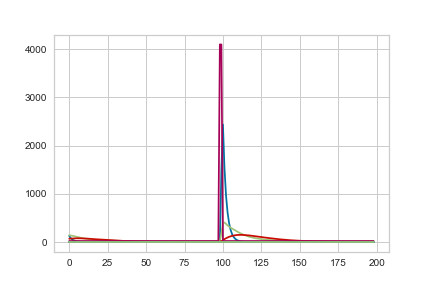

In [10]:
# resize FP data
fp_data_final = np.zeros((fp_data.shape[0], meta['num_fp_pts']))
fp_data_final[:, :fp_data.shape[1]] = fp_data[:, :]
fp_data = np.swapaxes(fp_data_final, 1, 0)

fig, ax = plt.subplots()
ax.plot(fp_data_final[t_cropping[0]:t_cropping[1], :])

In [11]:
# Write data
zda_writer = ZDA_Writer()
zda_writer.write_zda_to_file(raw_data, meta, selected_filename + ".zda", rli, fp_data[:, t_cropping[0]:t_cropping[1]])